## 使用CRF实现中文命名实体识别（NER）

目录

* [数据集说明](#数据集说明)
* [BiLSTM-CRF实现说明](#BiLSTM-CRF实现说明)
* [实验环境说明](#实验环境说明)
* [1.配置](#1.配置)
* [2.加载数据](#2.加载数据）)
* [3.搭建模型](#3.搭建模型)
* [4.模型训练&保存模型](#4.模型训练&保存模型)
* [5.测试](#5.测试)
* [6.预测](#6.预测)

## 数据集说明

数据集：人民日报 中文 NER数据集

数据集说明：实体为人名（PER）、地名（LOC）和组织机构名（ORG）。数据集一行对应一个中文字符以及标注符号，标注系统采用BIO系统。

其数据格式如下：

In [ ]:
海 O
钓 O
比 O
赛 O
地 O
点 O
在 O
厦 B-LOC
门 I-LOC
与 O
金 B-LOC
门 I-LOC
之 O
间 O
的 O
海 O
域 O
。 O

## BiLSTM-CRF实现说明

LSTM 一般已经足以用于词性标注、NER等任务，但是再与CRF结合后，能在CRF融合上下文局部特征的优势加持下，使得序列模型对于NER上的性能能有不错的提升。

当已知观测序列$x$和状态序列$y$后，CRF计算条件概率公式为：

$$P(y|x)=\frac{\exp \{ score(x,y)\}}{\sum\limits_{y'}\exp \{ score(x,y)\}}$$

而$score(x,y)$如何计算呢？即就是序列的状态特征得分与转移特征得分的和：
$$\begin{aligned}score(x, y)&=transition\_score+emission\_score\\&=\sum\limits_{i=1}^{n+1}A_{y_{i-1},y_i}+\sum\limits_{i=1}^{n+1}P_{y_i,x_i}\end{aligned}$$

其中$P_{y_i,x_i}$表示标签tag 为$y_i$ 条件下，观测word为$x_i$的emission_score，其来自时间步长$i$处的BiLSTM的隐藏状态。

$A_{y_{i-1},y_i}$表示从标签tag $y_{i-1}$转移到标签tag $y_{i}$的transition_score，transition_score存储在维度为tag_num的转移矩阵中，它将作为模型参数的一部分，
在训练中学习得到。

## 实验环境说明

|环境 | 版本/型号|
---|---
python| 3.6.9
pytorch| 1.7.0
cuda | 10.2
gpu| NVIDIA V100 (32G) x 4张

## 1.配置

In [32]:
import torch
import torchkeras
from torchcrf import CRF

from tqdm import tqdm
import datetime
import time
import copy
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
            confusion_matrix, classification_report

import numpy as np
import pandas as pd

cwd_dir = '/home/xijian/pycharm_projects/Magic-NLPer/MachineLearning/CRF条件随机场/'
data_base_dir = cwd_dir + 'data/rmrb/'
save_dir = cwd_dir + 'save/'
imgs_dir = cwd_dir + 'imgs/'

pad_token = '<pad>'
pad_id = 0
unk_token = '<unk>'
unk_id = 1

tag_to_id = {'<pad>': 0, 'O': 1, 'B-LOC': 2, 'I-LOC': 3, 'B-PER': 4, 'I-PER': 5, 'B-ORG': 6, 'I-ORG': 7}
id_to_tag = {id: tag for tag, id in tag_to_id.items()}
word_to_id = {'<pad>': 0, '<unk>': 1}
tags_num = len(tag_to_id)

LR = 1e-3
EPOCHS = 30

maxlen = 60
# total_words = 4000

embedding_dim = 100
hidden_size = 128
batch_size = 512

## 2.加载数据

In [2]:
# 读取数据  数据格式：字 tag
def read_data(filepath):
    sentences = []
    tags = []
    with open(filepath, 'r', encoding='utf-8') as f:
        tmp_sentence = []
        tmp_tags = []
        for line in f:
            if line == '\n' and len(tmp_sentence) != 0:
                assert len(tmp_sentence) == len(tmp_tags)
                sentences.append(tmp_sentence)
                tags.append(tmp_tags)
                tmp_sentence = []
                tmp_tags = []
            else:
                line = line.strip().split(' ')
                tmp_sentence.append(line[0])
                tmp_tags.append(line[1])
        if len(tmp_sentence) != 0:
            assert len(tmp_sentence) == len(tmp_tags)
            sentences.append(tmp_sentence)
            tags.append(tmp_tags)
    return sentences, tags

查看和分析一下数据，有助于设置一些超参，例如vocab_size、max_length等等

In [3]:
sentences, tags = read_data(data_base_dir + 'train.txt')
print(sentences[0], tags[0])

s_lengths = [len(s) for s in sentences]
print('最大句子长度：{}, 最小句子长度：{}, 平均句子长度：{:.2f}, 句子长度中位数：{:.2f}'.format(
    max(s_lengths), min(s_lengths), np.mean(s_lengths), np.median(s_lengths)))
df_len = pd.DataFrame({'s_len': s_lengths})
print(df_len.describe())

['海', '钓', '比', '赛', '地', '点', '在', '厦', '门', '与', '金', '门', '之', '间', '的', '海', '域', '。'] ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'I-LOC', 'O', 'B-LOC', 'I-LOC', 'O', 'O', 'O', 'O', 'O', 'O']
最大句子长度：574, 最小句子长度：6, 平均句子长度：46.93, 句子长度中位数：40.00
              s_len
count  20864.000000
mean      46.931557
std       30.077038
min        6.000000
25%       28.000000
50%       40.000000
75%       58.000000
max      574.000000


句子长度分布图：


<AxesSubplot:title={'center':'sentence length '}, ylabel='Frequency'>

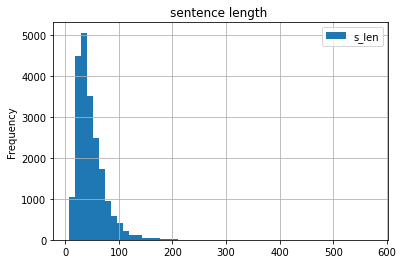

In [4]:
print('句子长度分布图：')
# df_len.s_len.hist(bins=50)
df_len.plot.hist('s_len',  grid=True, title='sentence length ', bins=50)
# plt.show()


分位点为0.774的句子长度:60


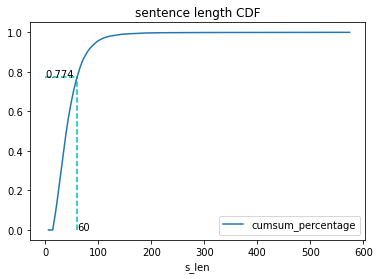

In [5]:
from collections import Counter
# df_len = df_len.sort_values(by='s_len', axis=0, ascending=True).reset_index(drop=True)
c = Counter(s_lengths) # 句子长度： 该长度对应的句子数
df_cumsum = pd.DataFrame(c.items(), columns=['s_len', 'cnt'])
df_cumsum = df_cumsum.sort_values(by='s_len', axis=0, ascending=True).reset_index(drop=True)
# df_cumsum.head()
df_cumsum['cumsum'] = df_cumsum['cnt'].cumsum()
# df_cumsum.head()
df_cumsum['cumsum_percentage'] = df_cumsum['cumsum']/len(sentences)
# df_cumsum.head()
# df_cumsum.tail()
ax = df_cumsum.plot('s_len', 'cumsum_percentage', title='sentence length CDF')
# print(ax)
# 寻找句子长度为100的分位点（或者直接从分位点如0.90去找句子长度也行）
quantile = 0
quantile_len = 60
for i,row in df_cumsum.iterrows():
    if row['s_len'] >= quantile_len:
        quantile = round(row['cumsum_percentage'], 3)
        break
print("\n分位点为%s的句子长度:%d" % (quantile, quantile_len))
ax.hlines(quantile, 0, quantile_len, colors="c", linestyles="dashed")
ax.vlines(quantile_len, 0, quantile, colors="c", linestyles="dashed")
ax.text(0, quantile, str(quantile))
ax.text(quantile_len, 0, str(quantile_len))
plt.show()

所以可以设置最大句子长度为60，因为已经覆盖了3/4的句子

In [41]:
def build_vocab(sentences):
    global word_to_id
    for sentence in sentences:  # 建立word到索引的映射
        for word in sentence:
            if word not in word_to_id:
                word_to_id[word] = len(word_to_id)
    return word_to_id

word_to_id = build_vocab(sentences)
print('vocab size:', len(word_to_id))

vocab size: 4314


In [7]:
def convert_to_ids_and_padding(seqs, to_ids):
    ids = []
    for seq in seqs:
        if len(seq)>=maxlen: # 截断
            ids.append([to_ids[w] if w in to_ids else unk_id for w in seq[:maxlen]])
        else: # padding
            ids.append([to_ids[w] if w in to_ids else unk_id for w in seq] + [0]*(maxlen-len(seq)))

    return torch.tensor(ids, dtype=torch.long)

In [8]:
def load_data(filepath, word_to_id, shuffle=False):
    sentences, tags = read_data(filepath)

    inps = convert_to_ids_and_padding(sentences, word_to_id)
    trgs = convert_to_ids_and_padding(tags, tag_to_id)

    inp_dset = torch.utils.data.TensorDataset(inps, trgs)
    inp_dloader = torch.utils.data.DataLoader(inp_dset,
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              num_workers=4)
    return inp_dloader

In [9]:
# 查看data pipeline是否生效
inp_dloader = load_data(data_base_dir + 'train.txt', word_to_id)
sample_batch = next(iter(inp_dloader))
print('sample_batch:', len(sample_batch), sample_batch[0].size(), sample_batch[0].dtype,
      sample_batch[1].size(), sample_batch[1].dtype)  # [b,60] int64

sample_batch: 2 torch.Size([512, 60]) torch.int64 torch.Size([512, 60]) torch.int64


## 3.搭建模型

In [16]:
ngpu = 1
device = 'cpu'

class BiLSTM_CRF(torch.nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(BiLSTM_CRF, self).__init__()

        self.hidden_size = hidden_size

        self.embedding = torch.nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=pad_id)
        self.bi_lstm = torch.nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size // 2, batch_first=True,
                                     bidirectional=True)  # , dropout=0.2)
        self.hidden2tag = torch.nn.Linear(hidden_size, tags_num)

        self.crf = CRF(num_tags=tags_num, batch_first=True)

    def init_hidden(self, batch_size):
        # device = 'cpu'
        _batch_size = batch_size//ngpu
        return (torch.randn(2, _batch_size, self.hidden_size // 2, device=device),
                torch.randn(2, _batch_size, self.hidden_size // 2, device=device))  # ([b=1,2,hidden_size//2], [b=1,2,hidden_size//2])


    def forward(self, inp):  # inp [b, seq_len=60]
        self.bi_lstm.flatten_parameters()

        embeds = self.embedding(inp)  # [b,seq_len]=>[b, seq_len, embedding_dim]
        lstm_out, _ = self.bi_lstm(embeds, None)  # lstm_out: =>[b, seq_len, hidden_size], #####################################################
        # lstm_out, self.hidden = self.bi_lstm(embeds, self.hidden)  # lstm_out: =>[b, seq_len, hidden_size], #####################################################
        # h_n: ([b,2,hidden_size//2], c_n: [b,2,hidden_size//2])

        logits = self.hidden2tag(lstm_out)  # [b, seq_len, hidden_size]=>[b, seq_len, tags_num]
        return logits # [b, seq_len=60, tags_num=10]

    # 计算CRF 条件对数似然，并返回其负值作为loss
    def crf_neg_log_likelihood(self, inp, tags, mask=None, inp_logits=False):  # [b, seq_len, tags_num], [b, seq_len]
        if inp_logits:
            logits = inp
        else:
            logits = self.forward(inp)

        if mask is None:
            mask = torch.logical_not(torch.eq(tags, torch.tensor(0)))  # =>[b, seq_len],每个元素为bool值，如果序列中有pad，则mask相应位置就为False
            mask = mask.type(torch.uint8)

        crf_llh = self.crf(logits, tags, mask, reduction='mean') # Compute the conditional log likelihood of a sequence of tags given emission scores
        # crf_llh = self.crf(logits, tags, mask) # Compute the conditional log likelihood of a sequence of tags given emission scores
        return -crf_llh

    def crf_decode(self, inp, mask=None, inp_logits=False):
        if inp_logits:
            logits = inp
        else:
            logits = self.forward(inp)

        if mask is None and inp_logits is False:
            mask = torch.logical_not(torch.eq(inp, torch.tensor(0)))  # =>[b, seq_len],每个元素为bool值，如果序列中有pad，则mask相应位置就为False
            mask = mask.type(torch.uint8)

        return self.crf.decode(emissions=logits, mask=mask)

# 查看模型
model = BiLSTM_CRF(len(word_to_id), hidden_size)
torchkeras.summary(model, input_shape=(60,), input_dtype=torch.int64)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1              [-1, 60, 100]         431,400
              LSTM-2              [-1, 60, 128]          84,992
            Linear-3                [-1, 60, 8]           1,032
Total params: 517,424
Trainable params: 517,424
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.000229
Forward/backward pass size (MB): 0.108032
Params size (MB): 1.973816
Estimated Total Size (MB): 2.082077
----------------------------------------------------------------


## 4.模型训练&保存模型

In [17]:
ngpu = 4 # 4张GPU卡
use_cuda = torch.cuda.is_available() # 检测是否有可用的gpu
device = torch.device("cuda:0" if (use_cuda and ngpu>0) else "cpu")
print('*'*8, 'device:', device)


# 设置评价指标
metric_func = lambda y_pred, y_true: accuracy_score(y_true, y_pred)
metric_name = 'acc'
df_history = pd.DataFrame(columns=["epoch", "loss", metric_name, "val_loss", "val_"+metric_name])

******** device: cuda:0


In [12]:
def train_step(model, inps, tags, optimizer):
    inps = inps.to(device)
    tags = tags.to(device)
    mask = torch.logical_not(torch.eq(inps, torch.tensor(0)))  # =>[b, seq_len]
    # 每个元素为bool值，如果序列中有pad，则mask相应位置就为False
    # mask = mask.type(torch.uint8)
    # mask = mask.to(device) # 由device上的数据生成的数据，也是在device上

    model.train()  # 设置train mode
    optimizer.zero_grad()  # 梯度清零


    # forward
    logits = model(inps)
    loss = model.module.crf_neg_log_likelihood(logits, tags, mask=mask, inp_logits=True)

    # backward
    loss.backward()  # 反向传播计算梯度
    optimizer.step()  # 更新参数

    preds = model.module.crf_decode(logits, mask=mask, inp_logits=True) # List[List]
    pred_without_pad = []
    for pred in preds:
        pred_without_pad.extend(pred)
    tags_without_pad = torch.masked_select(tags, mask).cpu().numpy() # 返回是1维张量
    # print('tags_without_pad:', tags_without_pad.shape, type(tags_without_pad)) # [5082] tensor
    metric = metric_func(pred_without_pad, tags_without_pad)
    # print('*'*8, metric) # 标量

    return loss.item(), metric

In [13]:
@torch.no_grad()
def validate_step(model, inps, tags):
    inps = inps.to(device)
    tags = tags.to(device)
    mask = torch.logical_not(torch.eq(inps, torch.tensor(0)))  # =>[b, seq_len],每个元素为bool值，如果序列中有pad，则mask相应位置就为False
    # mask = mask.type(torch.uint8)
    # mask = mask.to(device)

    model.eval()  # 设置eval mode

    # forward
    logits = model(inps)
    loss = model.module.crf_neg_log_likelihood(logits, tags, mask=mask, inp_logits=True)

    preds = model.module.crf_decode(logits, mask=mask, inp_logits=True)  # List[List]
    pred_without_pad = []
    for pred in preds:
        pred_without_pad.extend(pred)
    tags_without_pad = torch.masked_select(tags, mask).cpu().numpy()  # 返回是1维张量
    metric = metric_func(pred_without_pad, tags_without_pad)
    # print('*' * 8, metric) # 标量

    return loss.item(), metric

In [14]:
# 打印时间
def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m_%d %H:%M:%S')
    print('\n' + "=========="*8 + '%s'%nowtime)


def train_model(model, train_dloader, val_dloader, optimizer, num_epochs=10, print_every=150):
    starttime = time.time()
    print('*' * 27, 'start training...')
    printbar()

    best_metric = 0.
    for epoch in range(1, num_epochs+1):
        # 训练
        loss_sum, metric_sum = 0., 0.
        for step, (inps, tags) in enumerate(train_dloader, start=1):
            loss, metric = train_step(model, inps, tags, optimizer)
            loss_sum += loss
            metric_sum += metric

            # 打印batch级别日志
            if step % print_every == 0:
                print('*'*27, f'[step = {step}] loss: {loss_sum/step:.3f}, {metric_name}: {metric_sum/step:.3f}')

        # 验证 一个epoch的train结束，做一次验证
        val_loss_sum, val_metric_sum = 0., 0.
        for val_step, (inps, tags) in enumerate(val_dloader, start=1):
            val_loss, val_metric = validate_step(model, inps, tags)
            val_loss_sum += val_loss
            val_metric_sum += val_metric


        # 记录和收集 1个epoch的训练和验证信息
        # columns=['epoch', 'loss', metric_name, 'val_loss', 'val_'+metric_name]
        record = (epoch, loss_sum/step, metric_sum/step, val_loss_sum/val_step, val_metric_sum/val_step)
        df_history.loc[epoch - 1] = record

        # 打印epoch级别日志
        print('EPOCH = {} loss: {:.3f}, {}: {:.3f}, val_loss: {:.3f}, val_{}: {:.3f}'.format(
               record[0], record[1], metric_name, record[2], record[3], metric_name, record[4]))
        printbar()

        # 保存最佳模型参数
        current_metric_avg = val_metric_sum/val_step
        if current_metric_avg > best_metric:
            best_metric = current_metric_avg
            checkpoint = save_dir + f'epoch{epoch:03d}_valacc{current_metric_avg:.3f}_ckpt.tar'
            if device.type == 'cuda' and ngpu > 1:
                model_sd = copy.deepcopy(model.module.state_dict())
            else:
                model_sd = copy.deepcopy(model.state_dict())
            # 保存
            torch.save({
                'loss': loss_sum / step,
                'epoch': epoch,
                'net': model_sd,
                'opt': optimizer.state_dict(),
            }, checkpoint)


    endtime = time.time()
    time_elapsed = endtime - starttime
    print('*' * 27, 'training finished...')
    print('*' * 27, 'and it costs {} h {} min {:.2f} s'.format(int(time_elapsed // 3600),
                                                               int((time_elapsed % 3600) // 60),
                                                               (time_elapsed % 3600) % 60))

    print('Best val Acc: {:4f}'.format(best_metric))
    return df_history

### 开始训练

In [18]:
train_dloader = load_data(data_base_dir + 'train.txt', word_to_id)
val_dloader = load_data(data_base_dir + 'val.txt', word_to_id)

model = BiLSTM_CRF(len(word_to_id), hidden_size)
model = model.to(device)
if ngpu > 1:
    model = torch.nn.DataParallel(model, device_ids=list(range(ngpu)))  # 设置并行执行  device_ids=[0,1,2,3]

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
train_model(model, train_dloader, val_dloader, optimizer, num_epochs=EPOCHS, print_every=50)

*************************** start training...

================================================================================2021-02_10 15:40:52
EPOCH = 1 loss: 45.688, acc: 0.801, val_loss: 20.320, val_acc: 0.886

================================================================================2021-02_10 15:41:16
EPOCH = 2 loss: 19.270, acc: 0.883, val_loss: 17.360, val_acc: 0.886

================================================================================2021-02_10 15:41:43
EPOCH = 3 loss: 16.447, acc: 0.884, val_loss: 14.993, val_acc: 0.890

================================================================================2021-02_10 15:42:07
EPOCH = 4 loss: 14.100, acc: 0.893, val_loss: 12.828, val_acc: 0.902

================================================================================2021-02_10 15:42:36
EPOCH = 5 loss: 11.959, acc: 0.907, val_loss: 10.922, val_acc: 0.915

================================================================================2021-02_10 15:43:04
EPO

,epoch,loss,acc,val_loss,val_acc
0,1.0,45.687649,0.801478,20.319972,0.885931
1,2.0,19.270487,0.882515,17.359610,0.886046
2,3.0,16.446749,0.884191,14.992622,0.890471
3,4.0,14.099821,0.893419,12.827554,0.902364
4,5.0,11.959304,0.906506,10.921850,0.915174
5,6.0,10.118494,0.919399,9.352380,0.926360
6,7.0,8.649001,0.930854,8.150103,0.934836
7,8.0,7.530997,0.939349,7.258168,0.941337
8,9.0,6.677365,0.945722,6.582935,0.946342
9,10.0,6.007839,0.950506,6.055818,0.950501


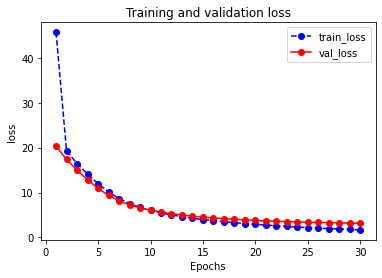

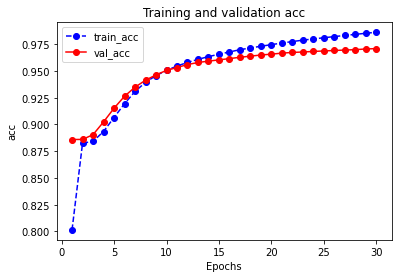

In [20]:
# 绘制训练曲线
def plot_metric(df_history, metric):
    plt.figure()

    train_metrics = df_history[metric]
    val_metrics = df_history['val_' + metric]  #

    epochs = range(1, len(train_metrics) + 1)

    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')  #

    plt.title('Training and validation ' + metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_" + metric, 'val_' + metric])

    plt.savefig(imgs_dir + metric + '.png')  # 保存图片
    plt.show()

plot_metric(df_history, 'loss')
plot_metric(df_history, metric_name)

### 5.测试

In [21]:
@torch.no_grad()
def eval_step(model, inps, tags):
    inps = inps.to(device)
    tags = tags.to(device)
    mask = torch.logical_not(torch.eq(inps, torch.tensor(0)))  # =>[b, seq_len],每个元素为bool值，如果序列中有pad，则mask相应位置就为False
    # mask = mask.type(torch.uint8)
    # mask = mask.to(device)

    # forward
    logits = model(inps)
    preds = model.module.crf_decode(logits, mask=mask, inp_logits=True)  # List[List]
    pred_without_pad = []
    for pred in preds:
        pred_without_pad.extend(pred)
    tags_without_pad = torch.masked_select(tags, mask).cpu()  # 返回是1维张量

    return torch.tensor(pred_without_pad), tags_without_pad

In [22]:
def evaluate(model, test_dloader):
    model.eval()  # 设置eval mode
    starttime = time.time()
    print('*' * 27, 'start evaluating...')
    printbar()
    preds, labels = [], []
    for step, (inps, tags) in enumerate(tqdm(test_dloader), start=1):
        pred, tags = eval_step(model, inps, tags)
        preds.append(pred)
        labels.append(tags)

    y_true = torch.cat(labels, dim=0)
    y_pred = torch.cat(preds, dim=0)
    endtime = time.time()
    print('evaluating costs: {:.2f}s'.format(endtime - starttime))
    return y_true.cpu(), y_pred.cpu()

In [24]:
def get_metrics(y_true, y_pred):
    average = 'weighted'
    print('*'*27, average+'_precision_score:{:.3f}'.format(precision_score(y_true, y_pred, average=average)))
    print('*'*27, average+'_recall_score:{:.3}'.format(recall_score(y_true, y_pred, average=average)))
    print('*'*27, average+'_f1_score:{:.3f}'.format(f1_score(y_true, y_pred, average=average)))

    print('*'*27, 'accuracy:{:.3f}'.format(accuracy_score(y_true, y_pred)))
    print('*'*27, 'confusion_matrix:\n', confusion_matrix(y_true, y_pred))
    print('*'*27, 'classification_report:\n', classification_report(y_true, y_pred))

### 开始测试

In [35]:
print('vocab size:', len(word_to_id))

checkpoint = save_dir + 'epoch030_valacc0.971_ckpt.tar'

# 加载测试数据
test_dloader = load_data(data_base_dir + 'test.txt', word_to_id)

# 加载模型
reloaded_model = BiLSTM_CRF(len(word_to_id), hidden_size)
reloaded_model = reloaded_model.to(device)
if ngpu > 1:
    reloaded_model = torch.nn.DataParallel(reloaded_model, device_ids=list(range(ngpu)))  # 设置并行执行

print('*' * 27, 'Loading model weights...')
# ckpt = torch.load(checkpoint, map_location=device)  # dict  save在CPU 加载到GPU
ckpt = torch.load(checkpoint)  # dict  save在GPU 加载到 GPU
model_sd = ckpt['net']
if device.type == 'cuda' and ngpu > 1:
    reloaded_model.module.load_state_dict(model_sd)
else:
    reloaded_model.load_state_dict(model_sd)
print('*' * 27, 'Model loaded success!')

y_true, y_pred = evaluate(reloaded_model, test_dloader)
get_metrics(y_true, y_pred)

vocab size: 4314
*************************** Loading model weights...
*************************** Model loaded success!
*************************** start evaluating...

================================================================================2021-02_10 16:03:36
evaluating costs: 5.12s
*************************** weighted_precision_score:0.969
*************************** weighted_recall_score:0.97
*************************** weighted_f1_score:0.969
*************************** accuracy:0.970
*************************** confusion_matrix:
 [[166169    168    277     53    158    138    797]
 [   353   2533    110     39      3    124     18]
 [   540     50   3481      4     66      1    211]
 [   193     40      5   1414     16      6      5]
 [   328     12     61     12   2799      0     13]
 [   318    129      8     16      1   1464     83]
 [  1091     11    234      4     36     50   6540]]
*************************** classification_report:
               precision    recall 

100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


## 6.预测

In [36]:
def predict(model, sentence, word_to_id):
    inp_ids = [word_to_id[w] if w in word_to_id else unk_id for w in sentence]
    inp_ids = torch.tensor(inp_ids, dtype=torch.long).unsqueeze(dim=0)
    # print(inp_ids.shape)  # [56, 60]
    # forward
    logits = model(inp_ids)
    preds = model.crf_decode(logits, inp_logits=True)  # List[List]
    pred_ids = preds[0]
    pred_tags = [id_to_tag[tag_id] for tag_id in pred_ids]

    return pred_ids, pred_tags

In [37]:
def get_entity(pred_tags, pred_ids, sentence):
    ner = {'per':[], 'loc':[], 'org':[]}
    i = 0
    while i<len(pred_tags):
        if pred_tags[i]=='O' or pred_ids[i]==0:
            i += 1
        elif pred_tags[i]=='B-PER':
            j = i
            while j+1<len(pred_tags) and pred_tags[j+1]=='I-PER':
                j += 1
            #print('**********************', i, j)
            per = [w for w in sentence[i:j+1]]
            ner['per'].append(''.join(per))
            i = j+1
        elif pred_tags[i]=='B-LOC':
            j = i
            while j+1<len(pred_tags) and pred_tags[j+1]=='I-LOC':
                j += 1
            #print('**********************', i, j)
            loc = [w for w in sentence[i:j+1]]
            ner['loc'].append(''.join(loc))
            i = j+1
        elif pred_tags[i]=='B-ORG':
            j = i
            while j+1<len(pred_tags) and pred_tags[j+1]=='I-ORG':
                j += 1
            #print('**********************', i, j)
            org = [w for w in sentence[i:j+1]]
            ner['org'].append(''.join(org))
            i = j+1
        else:
            i += 1
    return ner

### 开始预测

In [40]:
# 加载模型
reloaded_model = BiLSTM_CRF(len(word_to_id), hidden_size)
print('*' * 27, 'Loading model weights...')
# ckpt = torch.load(checkpoint, map_location=device)  # dict  save在CPU 加载到GPU
ckpt = torch.load(checkpoint)  # dict  save在GPU 加载到 GPU
model_sd = ckpt['net']
reloaded_model.load_state_dict(model_sd)
print('*' * 27, 'Model loaded success!')

reloaded_model.eval()  # 设置eval mode

sentences = [
        '日本知名学者石川一成先生曾撰文说：面对宝顶大佛湾造像，看中华民族囊括外来文化的能力和创造能力，不禁使我目瞪口呆。',
        '5月12日，北京市怀柔县民政局、畜牧局领导来到驻守在偏远山区的武警北京一总队十支队十四中队。',
        '粉碎“四人帮”后，我家中的长辈们开始和溥杰先生恢复了联系。',
        '到了宋代，河西走廊为西夏所有，敦煌废弃，随着海上通商的兴旺，丝绸之路也就日渐衰落。',
        '丁丑盛夏之日，我冒着关内难挨的酷暑来到狼牙山下。',
        '金田集团向县政府递交了请求兼并蔡塘村的“工程建议书”报告，很快，报告就得到批准。'
]

for sentence in sentences:
    pred_ids, pred_tags = predict(reloaded_model, sentence, word_to_id)
    pred_ner = get_entity(pred_tags, pred_ids, sentence)  # 抽取实体
    print('*' * 10, 'sentence:', sentence)
    print('*' * 10, 'pred_ner:', pred_ner, '\n')


*************************** Loading model weights...
*************************** Model loaded success!
********** sentence: 日本知名学者石川一成先生曾撰文说：面对宝顶大佛湾造像，看中华民族囊括外来文化的能力和创造能力，不禁使我目瞪口呆。
********** pred_ner: {'per': ['石川一成'], 'loc': ['日本', '中华'], 'org': []} 

********** sentence: 5月12日，北京市怀柔县民政局、畜牧局领导来到驻守在偏远山区的武警北京一总队十支队十四中队。
********** pred_ner: {'per': [], 'loc': [], 'org': ['北京市怀柔县民政局', '畜牧局', '武警北京一总队十支队十四中队']} 

********** sentence: 粉碎“四人帮”后，我家中的长辈们开始和溥杰先生恢复了联系。
********** pred_ner: {'per': ['溥杰'], 'loc': [], 'org': []} 

********** sentence: 到了宋代，河西走廊为西夏所有，敦煌废弃，随着海上通商的兴旺，丝绸之路也就日渐衰落。
********** pred_ner: {'per': [], 'loc': ['河西走廊', '西夏', '敦煌'], 'org': []} 

********** sentence: 丁丑盛夏之日，我冒着关内难挨的酷暑来到狼牙山下。
********** pred_ner: {'per': ['丁丑盛夏'], 'loc': ['狼牙山'], 'org': []} 

********** sentence: 金田集团向县政府递交了请求兼并蔡塘村的“工程建议书”报告，很快，报告就得到批准。
********** pred_ner: {'per': [], 'loc': ['蔡塘村'], 'org': ['金田集团']} 

